In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import linear_model
from sklearn.metrics import r2_score

# Model preparation

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [4]:
def my_train_test_split(data, test_size, target, drop_cols = [], shuffle = True):
    X = data.drop(drop_cols+[target], axis = 1)
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = test_size, shuffle = shuffle)

    return X_train, X_test, y_train, y_test

def split_target_and_predictors(data, target, drop_cols = []):
    X = data.drop(drop_cols+[target], axis = 1)
    y = data[[target]]

    return X, y



def negeate_MSE(y_true, y_pred):
    mse = -mean_squared_error(y_true, y_pred)
    return mse


def cv(pipe, parameters, X_train, y_train, cf = 10):    
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring=make_scorer(negeate_MSE),
        n_jobs=-1,
        return_train_score=True,
        verbose=10, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

def getPipe(model, numerical_columns, categorical_columns):

    # Pipeline to handle continous parameters. Here the parameters are scaled 
    numeric_transformer = Pipeline([
        ('scale', StandardScaler())
    ])
    
    # Pipeline to handle categorical parameters. Here the categorical variables
    # which are missing is imputed by using the most frequent value
    # afterwards they are one-hot encoded.
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(
            missing_values = ' NaN',
            strategy = 'most_frequent')),
        ('hot', OneHotEncoder())
    ])
    
    # Split the data into continous and caterigorical using ColumnTransformer
    # and apply numeric_transformer and categorical_transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='drop'
    )
    
    # Build the final pipeline for model fitting
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipe



# Part 1

In [5]:
df = pd.read_csv(os.path.abspath('../data/Processed/Cities.csv'), index_col=0)

bla bla bla bla

In [6]:
X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)

bla bla bla bla

In [7]:
colum_names = X_train.columns

no_info_column = [
    'City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Typology'
]

columsn_with_nan = ['Bicycle_Modeshare_(%)', 'Congestion_(%)', 'Congestion_AM_Peak_(%)',
       'Congestion_PM_Peak_(%)', 'Traffic_Index', 'Travel_Time_Index',
       'Inefficiency_Index', 'Unemployment_Rate_(%)', 'Cost_of_Living_Index',
       'Rent_Index', 'Grocery_Index', 'Restaurant_Price_Index',
       'Local_Purchasing_Power_Index', 'Poverty_Rate_(%)', 'Safety_Index',
       'Pollution_Index_']

remove_columns = no_info_column + columsn_with_nan

categorical_columns = ['Continent']

numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]


bla bla

In [8]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

n1 = 50
n2 = 10
parameters = {
    'model__alpha': np.logspace(-5, 1, n1),
    'model__l1_ratio': np.linspace(0, 1, n2)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)


elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 10)


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:

In [9]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()

In [10]:
elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]

0.015264179671752334

In [11]:
elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

1.0

In [12]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Car_Modeshare_(%)',
                                                   'Public_Transit_Modeshare_(%)',
                                                   'Walking_Modeshare_(%)',
                                                   'Gasoline_Pump_Price_(USD/liter)',
                                                   'Road_Deaths_Rate_(per_1000)',
                                                   'Subway_Length_(km)',
                                                   'Subway_Length_Density_(per_km)',
                                                   'Subway_Stations_per_Hundred_Thousand',
                                                   '...
                                          

# Coefficients

In [13]:
def plot_coef(model, df):
    # get the column transformer object from the pipe object:
    ColumnTransformer = model.get_params()['estimator__steps'][0][1]

    # exstract the numerical and categorical columns
    numerical_features = ColumnTransformer.transformers[0][2]
    categorical_features = ColumnTransformer.transformers[1][2]

    # One hot encode the the names if there is categorical columns
    if categorical_columns:
        one_hot_names = [value.replace(" ", "_") for column in categorical_columns for value in df[column].value_counts().index]
    else:
        one_hot_names = []

    names = numerical_columns + one_hot_names

    coef_df = pd.DataFrame({
        'variable' : names,
        'coefficient' : model.best_estimator_.steps[-1][1].coef_,
        'feature' : np.concatenate((
            np.repeat('numeric_feature', len(numerical_columns)),
            np.repeat('categorical_feature', len(one_hot_names))
        ))
    })

    # Define figure, axes, and plot
    color_dict = {'numeric_feature': 'tab:blue', 'categorical_feature': 'tab:red'}

    # Manuelly adding legends...
    from matplotlib.lines import Line2D
    if len(coef_df['feature'].value_counts()) == 2:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6),
                        Line2D([0], [0], color='tab:red', lw=6)]
    else:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6)]


    fig, ax = plt.subplots(figsize=(20, 10))
    coef_df.plot(
        x = 'variable', y = 'coefficient', kind = 'bar',
        ax = ax, color = [color_dict[x] for x in coef_df.feature],
        legend = False
    )


    plt.title('Coefficients of Features',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=12)
    ax.set_xlabel(None)
    ax.legend(custom_lines, ['Numerical Feature', 'Categorical Feature'])
    plt.show()

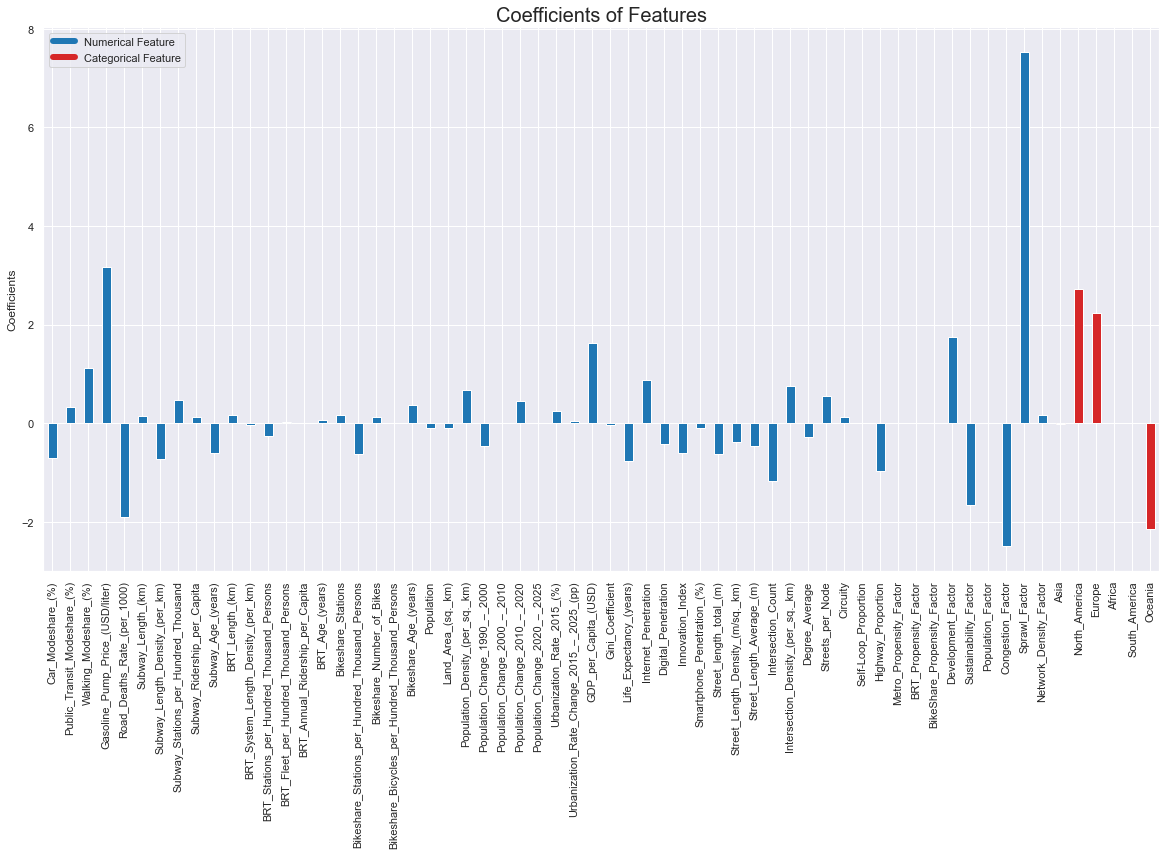

In [14]:
plot_coef(elastic_net_cv, X_train)

In [285]:
coef_df.count_values()

AttributeError: 'DataFrame' object has no attribute 'count_values'

In [15]:
## KNN Regression 
## Ensample models RANDom Forest

### Nort America

In [16]:
X_test = X[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')] 
y_test = y[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')]

X_train = X[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')] 
y_train = y[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')]

In [17]:
colum_names = X_train.columns

no_info_column = [
    'City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Continent', 'Typology'
]

columns_with_nan = ['Bicycle_Modeshare_(%)', 'Congestion_(%)', 'Congestion_AM_Peak_(%)',
       'Congestion_PM_Peak_(%)', 'Traffic_Index', 'Travel_Time_Index',
       'Inefficiency_Index', 'Unemployment_Rate_(%)', 'Cost_of_Living_Index',
       'Rent_Index', 'Grocery_Index', 'Restaurant_Price_Index',
       'Local_Purchasing_Power_Index', 'Poverty_Rate_(%)', 'Safety_Index',
       'Pollution_Index_']

remove_columns = no_info_column + columns_with_nan

categorical_columns = []

numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]


In [18]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

n1 = 50
n2 = 10
parameters = {
    'model__alpha': np.logspace(-5, 1, n1),
    'model__l1_ratio': np.linspace(0, 1, n2)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)


elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 10)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:

KeyboardInterrupt: 

In [ ]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]

In [ ]:
elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

In [22]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.408086681951909


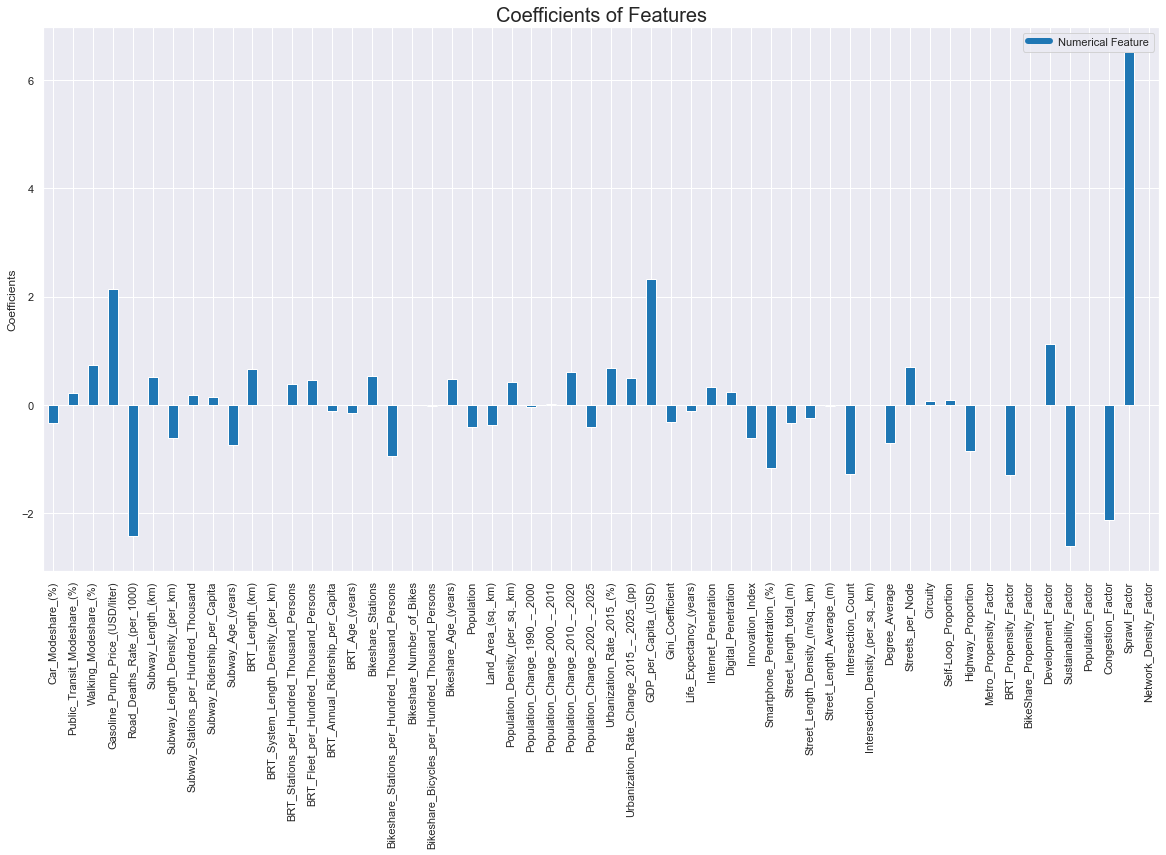

In [24]:
plot_coef(elastic_net_cv, X_train)